In [1]:
from pathlib import Path
import sys
sys.path.insert(0, str(Path().absolute().parent))

import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm, metrics
from sklearn.model_selection import cross_val_score, GridSearchCV, LeaveOneOut

from data.datasets import COLOR_DICT
from data.data_functions import DataLoader, PhaseTransform, NormalizePhaseTransform, SNIFFING_PATH, DerivTransform, NormalizeTransform
from data.sniffing_datasets import AlkanesShortSniff
from data.plot_functions import plot_array_data, plot_confusion_matrix
from data.utils import train_test_split, sort_by_set

SEED = 42

In [2]:
exp_set = AlkanesShortSniff()

train_set, test_set = train_test_split(exp_set, seed=SEED)

In [3]:
psi, labels = DataLoader(exp_set, transforms=[PhaseTransform, NormalizePhaseTransform], truncate_data_after=240,folder=SNIFFING_PATH).load()

Loading experimental data
(1/6) Pentane (8 exp.): [===================0] 100% complete
(2/6) Hexane (9 exp.): [===================0] 100% complete
(3/6) Heptane (9 exp.): [===================0] 100% complete
(4/6) Octane (10 exp.): [===================0] 100% complete
(5/6) Nonane (10 exp.): [===================0] 100% complete
(6/6) Decane (10 exp.): [===================0] 100% complete
Length of experimental set loaded: 56


#### Calculate SVM

In [4]:
def predict(clf, test, lbl):
    predicted = clf.predict(test)
    print("Validation accuracy: " + str(round(np.sum(predicted == lbl)/float(len(lbl)),3)) + " (" + str(np.sum(predicted == lbl)) + "/" + str(len(lbl)) + ")")

    scores = cross_val_score(clf, test, lbl, scoring="accuracy", cv=LeaveOneOut())
    print("Accuracy: %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

    return predicted

In [5]:
train_data, train_lbl, test_data, test_lbl = sort_by_set(psi, train_set, test_set)

##### Find best fitting SVM classifier

In [6]:
param_grid = {"kernel":("linear", "rbf"), "C":[0.1, 1, 10, 100], "gamma": [0.1, 1, 10, 100]}

clf = GridSearchCV(svm.SVC(), param_grid, cv=LeaveOneOut())
clf.fit(train_data, train_lbl)

print(clf.best_params_)

{'C': 100, 'gamma': 0.1, 'kernel': 'linear'}


In [7]:
SVC = svm.SVC(**clf.best_params_)
SVC.fit(train_data, train_lbl)
print("Training accuracy: " + str(SVC.score(train_data, train_lbl)) + " (" + str(len(train_data)) + ")")

Training accuracy: 0.9142857142857143 (35)


In [8]:
predicted = predict(SVC, test_data, test_lbl)
print(f"\nMismatches (true, pred): {[(lbl, pred) for lbl,pred in (zip(test_lbl, predicted)) if lbl!=pred]}")

Validation accuracy: 0.952 (20/21)
Accuracy: 0.67 accuracy with a standard deviation of 0.47

Mismatches (true, pred): [('Hexane', 'Heptane')]


#### Plot

/var/folders/27/tskcrgv97jvb7fgkqx5pcmtr0000gp/T/ipykernel_8033/566471988.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels([0,2.5,5,7.5,10])


Validation accuracy: 0.952 (20/21)
Accuracy: 0.67 accuracy with a standard deviation of 0.47


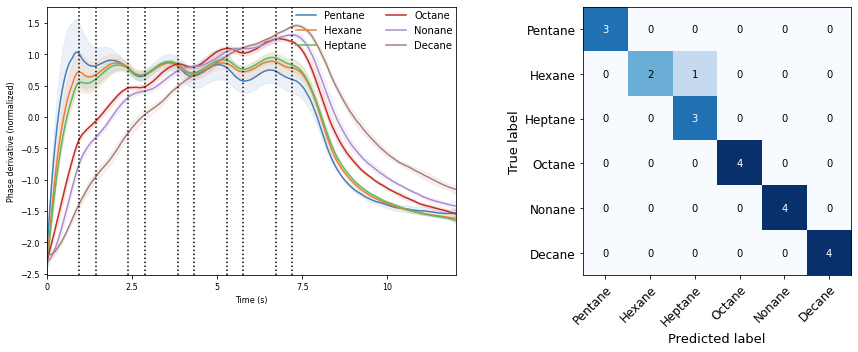

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

linestyle_dict = dict([
    ('Pentane', '-'),
    ('Hexane', '-'),
    ('Heptane', '-'),
    ('Octane', '-'),
    ('Nonane', '-'),
    ('Decane', '-'),
    ('Ethanol', ':'),
    ('Water', ':'),
    ('Acetone', ':'),
    ('Toluene', '-'),
    ('Acetonitrile', ':')
])

plot_array_data(exp_set, psi, [0,240], color_dict=COLOR_DICT, ax=axes[0])
axes[0].legend(loc='upper right', bbox_to_anchor=(1.015, 1.02), ncol=2, frameon=False, shadow=False)
axes[0].set_xticklabels([0,2.5,5,7.5,10])

ylim = axes[0].get_ylim()
for t in [1.,1.5,2.5,3.,4.,4.5,5.5,6.,7.,7.5]:
    axes[0].plot([t*19.2,t*19.2], ylim, 'k:')
axes[0].set_ylim(ylim)

#from IPython.utils import io
#with io.capture_output() as captured:
plot_confusion_matrix(test_lbl, predict(SVC, test_data, test_lbl), classes=list(exp_set.keys()), ax=axes[1])

plt.tight_layout()
# fig.savefig('./Fig6 - Sniffing.svg', dpi=1200)

Validation accuracy: 0.952 (20/21)
Accuracy: 0.952
Precision: 0.944
F1 Score: 0.943


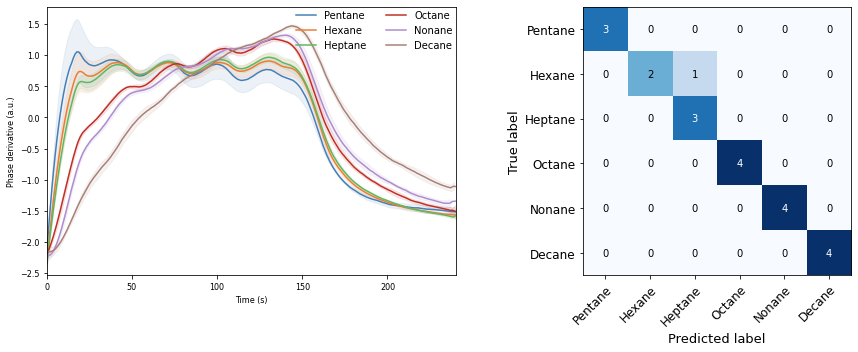

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

linestyle_dict = dict([
    ('Pentane', '-'),
    ('Hexane', '-'),
    ('Heptane', '-'),
    ('Octane', '-'),
    ('Nonane', '-'),
    ('Decane', '-'),
    ('Ethanol', ':'),
    ('Water', ':'),
    ('Acetone', ':'),
    ('Toluene', '-'),
    ('Acetonitrile', ':')
])

plot_array_data(exp_set, psi, [0,240], color_dict=COLOR_DICT, ax=axes[0])
axes[0].legend(loc='upper right', bbox_to_anchor=(1.015, 1.02), ncol=2, frameon=False, shadow=False)

#from IPython.utils import io
#with io.capture_output() as captured:
plot_confusion_matrix(test_lbl, predict(SVC, test_data, test_lbl), classes=list(exp_set.keys()), ax=axes[1])

plt.tight_layout()